In [0]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import argparse, os, gzip, torch, time, pickle
import torch.nn as nn
import torch.optim as optim
import numpy as np
import imageio
import matplotlib.pyplot as plt

In [0]:
def dataloader(dataset, input_size, batch_size, split = 'train'):
  
  transform = transforms.Compose([##transforms.Resize((input_size, input_size)),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5], [0.5])
#                                   transforms.Normalize(mean = (0.5, 0.5, 0.5),
#                                                        std = (0.5, 0.5, 0.5))
  ])
  
  if dataset == 'mnist':
    data_loader = DataLoader(
        datasets.MNIST('data/mnist', train = True, download = True,
                       transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
  
  elif dataset == 'fashion-mnist':
    data_loader = DataLoader(
        datasets.FashionMNIST('data/fashion-mnist', train = True, download = True,
                              transform = transform),
        batch_size = batch_size, 
        shuffle = True
    )
    
  elif dataset == 'cifar10':
    data_loader = DataLoader(
        datasets.CIFAR10('data/cifar10', train = True, download = True,
                         transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
    
  elif dataset == 'svhn':
    data_loader = DataLoader(
        datasets.SVHN('data/svhn', split = split, download = True,
                      transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
    
  elif dataset == 'stl10':
    data_loader = DataLoader(
        datasets.STL10('data/stl10', split = split, download = True,
                       transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
    
  elif dataset == 'lsun-bed':
    data_loader = DataLoader(
        datasets.LSUN('data/lsun', classes = ['bedroom_train'],
                      transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
    
  return data_loader

In [0]:
def load_mnist(dataset):
  data_dir = os.path.join("./data", dataset)
  
  def extract_data(filename, num_data, head_size, data_size):
    with gzip.open(filename) as bytestream:
      bytestream.read(head_size)
      buf = bytestream.read(data_size * num_data)
      data = np.frombuffer(buf, dtype = np.uint8).astype(np.float)
    return data
  
  data = extract_data(data_dir + '/train-images-idx3-ubyte.gz', 60000, 16, 28 * 28)
  trX = data.reshape((60000, 28, 28, 1))
  
  data = extract_data(data_dir + '/train-labels-idx1-ubyte.gz', 60000, 8, 1)
  trY = data.reshape((60000))
  
  data = extract_data(data_dir + '/t10k-images-idx3-ubyte.gz', 10000, 16, 28 * 28)
  teX = data.reshape((10000, 28, 28, 1))
  
  data = extract_data(data_dir + '/t10k-labels-idx1-ubyte.gz', 10000, 8, 1)
  teY = data.reshape((10000))
  
  trY = np.asarray(trY).astype(np.int)
  teY = np.asarray(teY)
  
  X = np.concatenate((trX, teX), axis = 0)
  y = np.concatenate((trY, teY), axis = 0).astype(np.int)
  
  seed = 547
  np.random.seed(seed)
  np.random.shuffle(X)
  np.random.seed(seed)
  np.random.shuffle(y)
  
  y_vec = np.zeros((len(y), 10), dtype = np.float)
  for i, label in enumerate(y):
    y_vec[i, y[i]] = 1
    
  
  X = X.transpose(0, 3, 1, 2) / 255.
  ## y_vec = y_vec.transpose(0, 3, 1, 2)
  
  
  X = torch.from_numpy(X).type(torch.FloatTensor)
  y_vec = torch.from_numpy(y_vec).type(torch.FloatTensor)
  return X, y_vec
  

In [0]:
def load_celebA(dir, transform, batch_size, shuffle):
  
  
##    transform = transforms.Compose([
##       transforms.CenterCrop(160),
##       transforms.Scale(64),
##       transforms.ToTensor(),
##       transform.Normalize(mean = (0.5, 0.5, 0.5),
##                           std = (0.5, 0.5, 0.5))
##    ])

##    data_dir = 'data/celebA'    ## this path depends on your computer
  
  dset = datasets.ImageFolder(dir, transform)
  data_loader = torch.utils.data.DataLoader(dset, batch_size, shuffle)
  
  return data_loader

In [0]:
def print_network(net):
  num_params = 0
  for param in net.parameters():
    num_params += param.numel()
  print(net)
  print('Total number of parameters: %d' % num_params)

In [0]:
def save_images(images, size, image_path):
  return imsave(images, size, image_path)

def imsave(images, size, path):
  image = np.squeeze(merge(images, size))
#   image = image.astype(np.uint8)
  return imageio.imwrite(path, image)

In [0]:
def merge(images, size):
  h, w = images.shape[1], images.shape[2]
  
  if(images.shape[3] in (3, 4)):
    c = images.shape[3]
    img = np.zeros((h * size[0], w * size[1], c))
    for idx, image in enumerate(images):
      i = idx % size[1]
      j = idx // size[1]
      img[j * h: j * h + h, i * w: i * w + w, :] = image
    return img
  
  elif images.shape[3] == 1:
    img = np.zeros((h * size[0], w * size[1]))
    for idx, image in enumerate(images):
      i = idx % size[1]
      j = idx // size[1]
      img[j * h: j * h + h, i * w: i * w + w] = image[:, :, 0]
    return img
  
  else:
    raise ValueError('in merge(images, size) images parameter must have dimensions: HxW or HxWx3 or HxWx4')

In [0]:
def generate_animation(path, num):
  images = []
  for e in range(num):
    img_name = path + '_epoch%03d' % (e + 1) + '.png'
    images.append(imageio.imread(img_name))
  imageio.mimsave(path + '_generate_animation.gif', images, fps = 5)

In [0]:
def loss_plot(hist, path = 'Train_hist.png', model_name = ''):
  
  x = range(len(hist['D_loss']))
  
  y1 = hist['D_loss']
  y2 = hist['G_loss']
  
  plt.plot(x, y1, label = 'D_loss')
  plt.plot(x, y2, label = 'G_loss')
  
  plt.xlabel('Iter')
  plt.ylabel('Loss')
  
  plt.legend(loc = 4)
  plt.grid(True)
  plt.tight_layout()
  
  path = os.path.join(path, model_name + '_loss.png')
  
  plt.savefig(path)
  
  plt.close()

In [0]:
def initialize_weights(net):
  
  for m in net.modules():
    if isinstance(m, nn.Conv2d):
      m.weight.data.normal_(0, 0.02)
      m.bias.data.zero_()
    elif isinstance(m, nn.ConvTranspose2d):
      m.weight.data.normal_(0, 0.02)
      m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
      m.weight.data.normal_(0, 0.02)
      m.bias.data.zero_()

In [0]:
class generator(nn.Module):
  
  ## Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
  ## Architecture: FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
  
  def __init__(self, input_dim = 100, output_dim = 1, input_size = 32):
    super(generator, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.input_size = input_size
    
    self.fc = nn.Sequential(
        nn.Linear(self.input_dim, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
        nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
        nn.ReLU(),
    )
    
    self.deconv = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4, 2, 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
        nn.Tanh(),
    )
    
    initialize_weights(self)
    
  
  def forward(self, input):
    x = self.fc(input)
    x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
    x = self.deconv(x)
    return x

In [0]:
class discriminator(nn.Module):
  
  ## Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
  ## Architecture: (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
  
  def __init__(self, input_dim = 1, output_dim = 1, input_size = 32):
    super(discriminator, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.input_size = input_size
    
    self.conv = nn.Sequential(
        nn.Conv2d(self.input_dim, 64, 4, 2, 1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, 4, 2, 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
    )
    
    self.fc = nn.Sequential(
        nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, self.output_dim),
        nn.Sigmoid(),
    )
    
    initialize_weights(self)
    
  
  def forward(self, input):
    x = self.conv(input)
    x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
    x = self.fc(x)
    return x

In [0]:
class GAN(object):
  
  def __init__(self):
    ## parameters
    self.epoch = 50
    self.sample_num = 100
    self.batch_size = 64
    self.save_dir = 'models'
    self.result_dir = 'results'
    self.dataset = 'fashion-mnist'
    self.log_dir = 'logs'
    self.gpu_mode = True
    self.model_name = 'GAN'
    self.input_size = 28
    self.z_dim = 62
    
    
    ## load dataset
    self.data_loader = dataloader(self.dataset, 
                                  self.input_size,
                                  self.batch_size)
    data = self.data_loader.__iter__().__next__()[0]
    
    
    ## networks init
    self.G = generator(input_dim = self.z_dim,
                       output_dim = data.shape[1],
                       input_size = self.input_size)
    self.D = discriminator(input_dim = data.shape[1],
                           output_dim = 1,
                           input_size = self.input_size)
    self.G_optimizer = optim.Adam(self.G.parameters(),
                                  lr = 0.0002,
                                  betas = (0.5, 0.999))
    self.D_optimizer = optim.Adam(self.D.parameters(),
                                  lr = 0.0002,
                                  betas = (0.5, 0.999))
    
    
    if self.gpu_mode:
      self.G.cuda()
      self.D.cuda()
      self.BCE_loss = nn.BCELoss().cuda()
    else:
      self.BCE_loss = nn.BCELoss()
      
    
    print('----------Networks architecture-----------')
    print_network(self.G)
    print_network(self.D)
    print('------------------------------------------')
    
    
    ## fixed noise
    self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
    if self.gpu_mode:
      self.sample_z_ = self.sample_z_.cuda()
      
      
  def train(self):
    self.train_hist = {}
    self.train_hist['D_loss'] = []
    self.train_hist['G_loss'] = []
    self.train_hist['per_epoch_time'] = []
    self.train_hist['total_time'] = []
    
    self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
    if self.gpu_mode:
      self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()
      
    self.D.train()
    print('training start !')
    start_time = time.time()
    for epoch in range(self.epoch):
      self.G.train()
      epoch_start_time = time.time()
      for iter, (x_, _) in enumerate(self.data_loader):
        if iter == self.data_loader.dataset.__len__() // self.batch_size:
          break
          
        z_ = torch.rand((self.batch_size, self.z_dim))
        if self.gpu_mode:
          x_, z_ = x_.cuda(), z_.cuda()
          
        
        ## Update D network
        self.D_optimizer.zero_grad()
        
        D_real = self.D(x_)
        D_real_loss = self.BCE_loss(D_real, self.y_real_)
        
        G_ = self.G(z_)
        D_fake = self.D(G_)
        D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)
        
        D_loss = D_real_loss + D_fake_loss
        self.train_hist['D_loss'].append(D_loss.item())
        
        D_loss.backward()
        self.D_optimizer.step()
        
        
        ## Update G network
        self.G_optimizer.zero_grad()
        
        G_ = self.G(z_)
        D_fake = self.D(G_)
        G_loss = self.BCE_loss(D_fake, self.y_real_)
        self.train_hist['G_loss'].append(G_loss.item())
        
        G_loss.backward()
        self.G_optimizer.step()
        
        
        if ((iter + 1) % 100) == 0:
          print("Epoch: [%2d] [%4d / %4d] D_loss: %.8f, G_loss: %.8f" %
                ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size,
                 D_loss.item(), G_loss.item()))
          
      self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
      with torch.no_grad():
        self.visualize_results((epoch + 1))
        
    self.train_hist['total_time'].append(time.time() - start_time)
    print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.train_hist['per_epoch_time']),
                                                                   self.epoch, self.train_hist['total_time'][0]))
    print("Training finish! Saved training results")
    
    self.save()
    
    generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                       self.epoch)
    loss_plot(self.train_hist, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
    
    
  def visualize_results(self, epoch, fix = True):
    self.G.eval()
    
    if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
      os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)
      
    tot_num_samples = min(self.sample_num, self.batch_size)
    image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
    
    if fix:
      """ fixed noise """
      samples = self.G(self.sample_z_)
      
    else:
      """ random noise """
      sample_z_ = torch.rand((self.batch_size, self.z_dim))
      if self.gpu_mode:
        sample_z_ = sample_z_.cuda()
        
      samples = self.G(sample_z_)
      
    
    if self.gpu_mode:
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
    else:
      samples = samples.data.numpy().transpose(0, 2, 3, 1)
      
    
    samples = (samples + 1) / 2
    save_images(samples[:image_frame_dim * image_frame_dim, :, :, :],
                [image_frame_dim, image_frame_dim],
                self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')
    
    
  def save(self):
    save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)
    
    if not os.path.exists(save_dir):
      os.makedirs(save_dir)
      
    torch.save(self.G.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
    torch.save(self.D.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))
    
    with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
      pickle.dump(self.train_hist, f)
      
      
  def load(self):
    save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)
    
    self.G.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
    self.D.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))

In [14]:
def main():
  
  gan = GAN()
  
  gan.train()
  print(" [**] Training finished!")
  
  ## visualize learned generator
  gan.visualize_results(50)
  print(" [**] Testing finished!")
  
if __name__ == '__main__':
  main()

0it [00:00, ?it/s]

26427392it [00:01, 13862109.15it/s]                             


Extracting data/fashion-mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 96465.92it/s]                            
0it [00:00, ?it/s]

Extracting data/fashion-mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:01, 3917519.71it/s]                             
0it [00:00, ?it/s]

Extracting data/fashion-mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 29542.61it/s]            


Extracting data/fashion-mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
----------Networks architecture-----------
generator(
  (fc): Sequential(
    (0): Linear(in_features=62, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)
Total number of parameters: 6640193
discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(nega

Epoch: [ 2] [ 100 /  937] D_loss: 0.99319917, G_loss: 1.12165844
Epoch: [ 2] [ 200 /  937] D_loss: 1.03327119, G_loss: 1.03222430
Epoch: [ 2] [ 300 /  937] D_loss: 1.07386422, G_loss: 1.12418878
Epoch: [ 2] [ 400 /  937] D_loss: 1.08233786, G_loss: 1.03182697
Epoch: [ 2] [ 500 /  937] D_loss: 1.04676723, G_loss: 1.10002637
Epoch: [ 2] [ 600 /  937] D_loss: 1.02536941, G_loss: 1.19930983
Epoch: [ 2] [ 700 /  937] D_loss: 1.15412426, G_loss: 1.14824796
Epoch: [ 2] [ 800 /  937] D_loss: 0.96363914, G_loss: 1.17417872
Epoch: [ 2] [ 900 /  937] D_loss: 0.96950066, G_loss: 1.31322289


Epoch: [ 3] [ 100 /  937] D_loss: 1.03054821, G_loss: 1.09577489
Epoch: [ 3] [ 200 /  937] D_loss: 1.05416524, G_loss: 1.13066185
Epoch: [ 3] [ 300 /  937] D_loss: 0.98714304, G_loss: 1.12658870
Epoch: [ 3] [ 400 /  937] D_loss: 1.10756421, G_loss: 1.15920568
Epoch: [ 3] [ 500 /  937] D_loss: 0.84855163, G_loss: 1.26560307
Epoch: [ 3] [ 600 /  937] D_loss: 0.98717755, G_loss: 1.14615989
Epoch: [ 3] [ 700 /  937] D_loss: 1.06436229, G_loss: 1.18983185
Epoch: [ 3] [ 800 /  937] D_loss: 1.03415442, G_loss: 1.18895340
Epoch: [ 3] [ 900 /  937] D_loss: 1.10443330, G_loss: 1.21246910


Epoch: [ 4] [ 100 /  937] D_loss: 0.97693288, G_loss: 1.12324917
Epoch: [ 4] [ 200 /  937] D_loss: 1.04573917, G_loss: 1.18342602
Epoch: [ 4] [ 300 /  937] D_loss: 0.95645654, G_loss: 1.25245082
Epoch: [ 4] [ 400 /  937] D_loss: 0.95831794, G_loss: 1.20194936
Epoch: [ 4] [ 500 /  937] D_loss: 1.14983773, G_loss: 1.08373308
Epoch: [ 4] [ 600 /  937] D_loss: 0.99325919, G_loss: 1.38948572
Epoch: [ 4] [ 700 /  937] D_loss: 0.94967389, G_loss: 1.40201235
Epoch: [ 4] [ 800 /  937] D_loss: 1.03245544, G_loss: 1.30574346
Epoch: [ 4] [ 900 /  937] D_loss: 1.06418085, G_loss: 1.09694743


Epoch: [ 5] [ 100 /  937] D_loss: 0.94490993, G_loss: 1.29339528
Epoch: [ 5] [ 200 /  937] D_loss: 0.96404207, G_loss: 1.34932828
Epoch: [ 5] [ 300 /  937] D_loss: 0.95488226, G_loss: 1.38983595
Epoch: [ 5] [ 400 /  937] D_loss: 0.93418103, G_loss: 1.22316909
Epoch: [ 5] [ 500 /  937] D_loss: 0.94136935, G_loss: 1.32107043
Epoch: [ 5] [ 600 /  937] D_loss: 0.99658740, G_loss: 1.19689572
Epoch: [ 5] [ 700 /  937] D_loss: 0.93677604, G_loss: 1.29797995
Epoch: [ 5] [ 800 /  937] D_loss: 1.01300621, G_loss: 1.08320367
Epoch: [ 5] [ 900 /  937] D_loss: 0.95400274, G_loss: 1.25255632


Epoch: [ 6] [ 100 /  937] D_loss: 0.92149752, G_loss: 1.12687588
Epoch: [ 6] [ 200 /  937] D_loss: 1.07361913, G_loss: 1.18717504
Epoch: [ 6] [ 300 /  937] D_loss: 0.98313129, G_loss: 1.07130837
Epoch: [ 6] [ 400 /  937] D_loss: 1.15583944, G_loss: 1.14906406
Epoch: [ 6] [ 500 /  937] D_loss: 1.01479959, G_loss: 1.25591469
Epoch: [ 6] [ 600 /  937] D_loss: 0.88664281, G_loss: 1.30880284
Epoch: [ 6] [ 700 /  937] D_loss: 0.93827492, G_loss: 1.24080610
Epoch: [ 6] [ 800 /  937] D_loss: 0.93113339, G_loss: 1.34690201
Epoch: [ 6] [ 900 /  937] D_loss: 1.06150782, G_loss: 1.16262627


Epoch: [ 7] [ 100 /  937] D_loss: 0.92248702, G_loss: 1.47179341
Epoch: [ 7] [ 200 /  937] D_loss: 0.86295176, G_loss: 1.34595370
Epoch: [ 7] [ 300 /  937] D_loss: 0.94213510, G_loss: 1.20227408
Epoch: [ 7] [ 400 /  937] D_loss: 0.97148108, G_loss: 1.28524828
Epoch: [ 7] [ 500 /  937] D_loss: 0.90439647, G_loss: 1.14190114
Epoch: [ 7] [ 600 /  937] D_loss: 0.90369987, G_loss: 1.37029815
Epoch: [ 7] [ 700 /  937] D_loss: 1.01663435, G_loss: 1.40496099
Epoch: [ 7] [ 800 /  937] D_loss: 0.88750219, G_loss: 1.42581058
Epoch: [ 7] [ 900 /  937] D_loss: 0.83848107, G_loss: 1.47599471


Epoch: [ 8] [ 100 /  937] D_loss: 0.95867181, G_loss: 1.37370133
Epoch: [ 8] [ 200 /  937] D_loss: 0.87194991, G_loss: 1.37829733
Epoch: [ 8] [ 300 /  937] D_loss: 1.03004384, G_loss: 1.42956161
Epoch: [ 8] [ 400 /  937] D_loss: 0.99772465, G_loss: 1.17970097
Epoch: [ 8] [ 500 /  937] D_loss: 0.95594347, G_loss: 1.54169226
Epoch: [ 8] [ 600 /  937] D_loss: 0.82380801, G_loss: 1.37483072
Epoch: [ 8] [ 700 /  937] D_loss: 0.83835900, G_loss: 1.36117244
Epoch: [ 8] [ 800 /  937] D_loss: 0.99715501, G_loss: 1.46180046
Epoch: [ 8] [ 900 /  937] D_loss: 0.97940922, G_loss: 1.49519241


Epoch: [ 9] [ 100 /  937] D_loss: 0.78636700, G_loss: 1.48869407
Epoch: [ 9] [ 200 /  937] D_loss: 0.76737481, G_loss: 1.49412560
Epoch: [ 9] [ 300 /  937] D_loss: 0.96065372, G_loss: 1.36835599
Epoch: [ 9] [ 400 /  937] D_loss: 0.84852207, G_loss: 1.57700992
Epoch: [ 9] [ 500 /  937] D_loss: 0.96483541, G_loss: 1.49519956
Epoch: [ 9] [ 600 /  937] D_loss: 1.12251842, G_loss: 1.49191105
Epoch: [ 9] [ 700 /  937] D_loss: 0.87147444, G_loss: 1.46718776
Epoch: [ 9] [ 800 /  937] D_loss: 0.75361174, G_loss: 1.58730459
Epoch: [ 9] [ 900 /  937] D_loss: 1.01711750, G_loss: 1.46948373


Epoch: [10] [ 100 /  937] D_loss: 0.86685348, G_loss: 1.43345428
Epoch: [10] [ 200 /  937] D_loss: 0.84067750, G_loss: 1.42210042
Epoch: [10] [ 300 /  937] D_loss: 0.86482948, G_loss: 1.39827943
Epoch: [10] [ 400 /  937] D_loss: 1.07498395, G_loss: 1.21996117
Epoch: [10] [ 500 /  937] D_loss: 0.95597094, G_loss: 1.62723041
Epoch: [10] [ 600 /  937] D_loss: 0.86808205, G_loss: 1.30545235
Epoch: [10] [ 700 /  937] D_loss: 0.97767413, G_loss: 1.58457661
Epoch: [10] [ 800 /  937] D_loss: 0.73137701, G_loss: 1.39447987
Epoch: [10] [ 900 /  937] D_loss: 0.90357697, G_loss: 1.58602273


Epoch: [11] [ 100 /  937] D_loss: 0.87884778, G_loss: 1.37986088
Epoch: [11] [ 200 /  937] D_loss: 0.74090302, G_loss: 1.59607339
Epoch: [11] [ 300 /  937] D_loss: 0.77156687, G_loss: 1.56997550
Epoch: [11] [ 400 /  937] D_loss: 0.75543404, G_loss: 1.56445730
Epoch: [11] [ 500 /  937] D_loss: 0.85337371, G_loss: 1.46311426
Epoch: [11] [ 600 /  937] D_loss: 0.97440463, G_loss: 1.55345345
Epoch: [11] [ 700 /  937] D_loss: 0.90626502, G_loss: 1.62659621
Epoch: [11] [ 800 /  937] D_loss: 0.72232223, G_loss: 1.48734307
Epoch: [11] [ 900 /  937] D_loss: 0.85109437, G_loss: 1.54460776


Epoch: [12] [ 100 /  937] D_loss: 0.80329406, G_loss: 1.75875354
Epoch: [12] [ 200 /  937] D_loss: 0.73239410, G_loss: 1.64270782
Epoch: [12] [ 300 /  937] D_loss: 0.95628822, G_loss: 1.41192448
Epoch: [12] [ 400 /  937] D_loss: 0.86947662, G_loss: 1.51375556
Epoch: [12] [ 500 /  937] D_loss: 0.80990452, G_loss: 1.86756182
Epoch: [12] [ 600 /  937] D_loss: 0.71150225, G_loss: 1.69154561
Epoch: [12] [ 700 /  937] D_loss: 0.75708139, G_loss: 1.82169557
Epoch: [12] [ 800 /  937] D_loss: 0.76418543, G_loss: 1.72510147
Epoch: [12] [ 900 /  937] D_loss: 0.82561368, G_loss: 1.53910923


Epoch: [13] [ 100 /  937] D_loss: 0.83601117, G_loss: 1.47174454
Epoch: [13] [ 200 /  937] D_loss: 0.82821077, G_loss: 1.57307017
Epoch: [13] [ 300 /  937] D_loss: 0.86771595, G_loss: 1.74761200
Epoch: [13] [ 400 /  937] D_loss: 0.71849161, G_loss: 1.64537668
Epoch: [13] [ 500 /  937] D_loss: 0.75769413, G_loss: 1.47750533
Epoch: [13] [ 600 /  937] D_loss: 0.80017209, G_loss: 1.73855817
Epoch: [13] [ 700 /  937] D_loss: 0.87249392, G_loss: 1.46806538
Epoch: [13] [ 800 /  937] D_loss: 0.67233318, G_loss: 2.05260062
Epoch: [13] [ 900 /  937] D_loss: 0.81804848, G_loss: 1.49160981


Epoch: [14] [ 100 /  937] D_loss: 0.91203463, G_loss: 1.58438373
Epoch: [14] [ 200 /  937] D_loss: 0.65138406, G_loss: 1.88111496
Epoch: [14] [ 300 /  937] D_loss: 0.84325439, G_loss: 1.85523665
Epoch: [14] [ 400 /  937] D_loss: 0.70349288, G_loss: 1.71630251
Epoch: [14] [ 500 /  937] D_loss: 0.81661552, G_loss: 1.67004180
Epoch: [14] [ 600 /  937] D_loss: 0.99803114, G_loss: 1.84014583
Epoch: [14] [ 700 /  937] D_loss: 0.82365578, G_loss: 1.67531192
Epoch: [14] [ 800 /  937] D_loss: 0.72751844, G_loss: 1.77716756
Epoch: [14] [ 900 /  937] D_loss: 0.94175136, G_loss: 1.76795244


Epoch: [15] [ 100 /  937] D_loss: 0.83742011, G_loss: 2.01470041
Epoch: [15] [ 200 /  937] D_loss: 0.81670082, G_loss: 1.81479430
Epoch: [15] [ 300 /  937] D_loss: 0.65170443, G_loss: 1.73202014
Epoch: [15] [ 400 /  937] D_loss: 0.89938712, G_loss: 1.48895526
Epoch: [15] [ 500 /  937] D_loss: 0.81774735, G_loss: 1.86490333
Epoch: [15] [ 600 /  937] D_loss: 0.84193313, G_loss: 1.52888703
Epoch: [15] [ 700 /  937] D_loss: 0.70482349, G_loss: 2.05321598
Epoch: [15] [ 800 /  937] D_loss: 0.71529353, G_loss: 1.82980466
Epoch: [15] [ 900 /  937] D_loss: 0.72511178, G_loss: 1.69928479


Epoch: [16] [ 100 /  937] D_loss: 0.72356343, G_loss: 1.83960795
Epoch: [16] [ 200 /  937] D_loss: 0.69564843, G_loss: 1.92871547
Epoch: [16] [ 300 /  937] D_loss: 0.73475832, G_loss: 1.82638597
Epoch: [16] [ 400 /  937] D_loss: 0.61043084, G_loss: 1.88311791
Epoch: [16] [ 500 /  937] D_loss: 0.69839805, G_loss: 1.92098236
Epoch: [16] [ 600 /  937] D_loss: 0.84649801, G_loss: 1.55532122
Epoch: [16] [ 700 /  937] D_loss: 0.56744015, G_loss: 2.04561472
Epoch: [16] [ 800 /  937] D_loss: 0.74069118, G_loss: 1.78838313
Epoch: [16] [ 900 /  937] D_loss: 0.92983425, G_loss: 1.67239189


Epoch: [17] [ 100 /  937] D_loss: 0.54826725, G_loss: 1.97426391
Epoch: [17] [ 200 /  937] D_loss: 0.70744741, G_loss: 1.93072999
Epoch: [17] [ 300 /  937] D_loss: 0.75768602, G_loss: 2.05606747
Epoch: [17] [ 400 /  937] D_loss: 0.68149847, G_loss: 1.90716982
Epoch: [17] [ 500 /  937] D_loss: 0.83880401, G_loss: 1.93825018
Epoch: [17] [ 600 /  937] D_loss: 0.72217071, G_loss: 1.75427234
Epoch: [17] [ 700 /  937] D_loss: 0.65954381, G_loss: 1.82608366
Epoch: [17] [ 800 /  937] D_loss: 0.68060303, G_loss: 1.85933888
Epoch: [17] [ 900 /  937] D_loss: 0.66726303, G_loss: 2.02352023


Epoch: [18] [ 100 /  937] D_loss: 0.71319377, G_loss: 2.22129297
Epoch: [18] [ 200 /  937] D_loss: 0.59704536, G_loss: 2.03921700
Epoch: [18] [ 300 /  937] D_loss: 0.59754920, G_loss: 2.07437015
Epoch: [18] [ 400 /  937] D_loss: 0.75465822, G_loss: 1.92995715
Epoch: [18] [ 500 /  937] D_loss: 0.60057795, G_loss: 1.94629478
Epoch: [18] [ 600 /  937] D_loss: 0.91736054, G_loss: 1.59408641
Epoch: [18] [ 700 /  937] D_loss: 0.69897223, G_loss: 1.65554392
Epoch: [18] [ 800 /  937] D_loss: 0.65589690, G_loss: 1.92844093
Epoch: [18] [ 900 /  937] D_loss: 0.58141464, G_loss: 1.96844518


Epoch: [19] [ 100 /  937] D_loss: 0.60361904, G_loss: 2.23984098
Epoch: [19] [ 200 /  937] D_loss: 0.71388018, G_loss: 1.61211073
Epoch: [19] [ 300 /  937] D_loss: 0.73768032, G_loss: 2.00718880
Epoch: [19] [ 400 /  937] D_loss: 0.68683201, G_loss: 1.85464859
Epoch: [19] [ 500 /  937] D_loss: 0.59320199, G_loss: 1.96920156
Epoch: [19] [ 600 /  937] D_loss: 0.83836168, G_loss: 1.60541642
Epoch: [19] [ 700 /  937] D_loss: 1.06342530, G_loss: 2.27823496
Epoch: [19] [ 800 /  937] D_loss: 0.73531199, G_loss: 1.93225276
Epoch: [19] [ 900 /  937] D_loss: 0.58854795, G_loss: 2.11486602


Epoch: [20] [ 100 /  937] D_loss: 0.57845604, G_loss: 2.13968825
Epoch: [20] [ 200 /  937] D_loss: 0.91151571, G_loss: 1.90410972
Epoch: [20] [ 300 /  937] D_loss: 0.52627450, G_loss: 2.41847038
Epoch: [20] [ 400 /  937] D_loss: 0.51765203, G_loss: 2.27337718
Epoch: [20] [ 500 /  937] D_loss: 0.63823241, G_loss: 1.83108664
Epoch: [20] [ 600 /  937] D_loss: 0.72931135, G_loss: 2.14554763
Epoch: [20] [ 700 /  937] D_loss: 0.64191175, G_loss: 1.91662395
Epoch: [20] [ 800 /  937] D_loss: 0.83757710, G_loss: 1.67764378
Epoch: [20] [ 900 /  937] D_loss: 0.71439064, G_loss: 2.32851505


Epoch: [21] [ 100 /  937] D_loss: 0.66518819, G_loss: 2.19161081
Epoch: [21] [ 200 /  937] D_loss: 0.51283008, G_loss: 2.14518976
Epoch: [21] [ 300 /  937] D_loss: 0.63963854, G_loss: 2.16550112
Epoch: [21] [ 400 /  937] D_loss: 0.71982127, G_loss: 2.01496983
Epoch: [21] [ 500 /  937] D_loss: 0.64961034, G_loss: 2.11017823
Epoch: [21] [ 600 /  937] D_loss: 0.68263555, G_loss: 2.04580522
Epoch: [21] [ 700 /  937] D_loss: 0.62102753, G_loss: 2.18967700
Epoch: [21] [ 800 /  937] D_loss: 0.62442410, G_loss: 2.08361530
Epoch: [21] [ 900 /  937] D_loss: 0.51414847, G_loss: 2.22358894


Epoch: [22] [ 100 /  937] D_loss: 0.59670734, G_loss: 2.27140617
Epoch: [22] [ 200 /  937] D_loss: 0.52690369, G_loss: 2.39788866
Epoch: [22] [ 300 /  937] D_loss: 0.70619857, G_loss: 2.00628042
Epoch: [22] [ 400 /  937] D_loss: 0.82637793, G_loss: 1.71534705
Epoch: [22] [ 500 /  937] D_loss: 0.46556666, G_loss: 2.32220173
Epoch: [22] [ 600 /  937] D_loss: 0.84343624, G_loss: 1.87071252
Epoch: [22] [ 700 /  937] D_loss: 0.83671498, G_loss: 1.82669306
Epoch: [22] [ 800 /  937] D_loss: 0.68703747, G_loss: 2.40701580
Epoch: [22] [ 900 /  937] D_loss: 0.80812305, G_loss: 1.80629241


Epoch: [23] [ 100 /  937] D_loss: 1.10727334, G_loss: 2.04314756
Epoch: [23] [ 200 /  937] D_loss: 0.63254106, G_loss: 1.93586278
Epoch: [23] [ 300 /  937] D_loss: 0.71294260, G_loss: 2.23552680
Epoch: [23] [ 400 /  937] D_loss: 0.57700592, G_loss: 2.30641699
Epoch: [23] [ 500 /  937] D_loss: 0.81867743, G_loss: 2.76594877
Epoch: [23] [ 600 /  937] D_loss: 0.42713755, G_loss: 2.59462404
Epoch: [23] [ 700 /  937] D_loss: 0.78332508, G_loss: 1.86772466
Epoch: [23] [ 800 /  937] D_loss: 0.60968900, G_loss: 2.06926894
Epoch: [23] [ 900 /  937] D_loss: 0.51802087, G_loss: 2.21117783


Epoch: [24] [ 100 /  937] D_loss: 0.56531119, G_loss: 2.29903626
Epoch: [24] [ 200 /  937] D_loss: 0.63805187, G_loss: 2.01364684
Epoch: [24] [ 300 /  937] D_loss: 0.55661845, G_loss: 1.89227676
Epoch: [24] [ 400 /  937] D_loss: 0.57188326, G_loss: 2.28044939
Epoch: [24] [ 500 /  937] D_loss: 0.66815227, G_loss: 2.07129741
Epoch: [24] [ 600 /  937] D_loss: 0.70981348, G_loss: 2.65633965
Epoch: [24] [ 700 /  937] D_loss: 0.61969465, G_loss: 1.77975059
Epoch: [24] [ 800 /  937] D_loss: 0.51000810, G_loss: 2.09091139
Epoch: [24] [ 900 /  937] D_loss: 0.67168057, G_loss: 2.45216751


Epoch: [25] [ 100 /  937] D_loss: 0.65894079, G_loss: 1.76826203
Epoch: [25] [ 200 /  937] D_loss: 0.56976253, G_loss: 2.33009028
Epoch: [25] [ 300 /  937] D_loss: 0.64021814, G_loss: 2.40805840
Epoch: [25] [ 400 /  937] D_loss: 0.58686274, G_loss: 1.90077412
Epoch: [25] [ 500 /  937] D_loss: 0.72996283, G_loss: 2.31598616
Epoch: [25] [ 600 /  937] D_loss: 0.79460418, G_loss: 2.06678724
Epoch: [25] [ 700 /  937] D_loss: 0.58329117, G_loss: 2.30388141
Epoch: [25] [ 800 /  937] D_loss: 0.60416710, G_loss: 2.36208963
Epoch: [25] [ 900 /  937] D_loss: 0.57120180, G_loss: 2.22606087


Epoch: [26] [ 100 /  937] D_loss: 0.49861547, G_loss: 2.42176151
Epoch: [26] [ 200 /  937] D_loss: 0.47933102, G_loss: 2.69250393
Epoch: [26] [ 300 /  937] D_loss: 0.57960391, G_loss: 2.47896624
Epoch: [26] [ 400 /  937] D_loss: 0.71927881, G_loss: 2.14988184
Epoch: [26] [ 500 /  937] D_loss: 0.81297904, G_loss: 2.08181000
Epoch: [26] [ 600 /  937] D_loss: 0.60268682, G_loss: 2.33276200
Epoch: [26] [ 700 /  937] D_loss: 0.47606456, G_loss: 2.57623243
Epoch: [26] [ 800 /  937] D_loss: 0.47865075, G_loss: 2.43013287
Epoch: [26] [ 900 /  937] D_loss: 0.66310799, G_loss: 2.38370228


Epoch: [27] [ 100 /  937] D_loss: 0.61278081, G_loss: 2.02954197
Epoch: [27] [ 200 /  937] D_loss: 0.69015801, G_loss: 2.40127850
Epoch: [27] [ 300 /  937] D_loss: 0.65450954, G_loss: 2.75780344
Epoch: [27] [ 400 /  937] D_loss: 0.72651410, G_loss: 2.47898173
Epoch: [27] [ 500 /  937] D_loss: 0.55029279, G_loss: 2.31704760
Epoch: [27] [ 600 /  937] D_loss: 0.53241169, G_loss: 2.44868588
Epoch: [27] [ 700 /  937] D_loss: 0.36663356, G_loss: 2.81375647
Epoch: [27] [ 800 /  937] D_loss: 0.68326753, G_loss: 2.14673948
Epoch: [27] [ 900 /  937] D_loss: 0.76736122, G_loss: 1.74725795


Epoch: [28] [ 100 /  937] D_loss: 0.64001566, G_loss: 2.38484049
Epoch: [28] [ 200 /  937] D_loss: 0.62005872, G_loss: 2.31940794
Epoch: [28] [ 300 /  937] D_loss: 0.58384359, G_loss: 2.46476936
Epoch: [28] [ 400 /  937] D_loss: 0.82213479, G_loss: 1.98665190
Epoch: [28] [ 500 /  937] D_loss: 0.47812265, G_loss: 2.63277936
Epoch: [28] [ 600 /  937] D_loss: 0.54168570, G_loss: 2.20281243
Epoch: [28] [ 700 /  937] D_loss: 0.47029155, G_loss: 2.53796482
Epoch: [28] [ 800 /  937] D_loss: 0.57820016, G_loss: 2.79733372
Epoch: [28] [ 900 /  937] D_loss: 0.59096980, G_loss: 2.20627618


Epoch: [29] [ 100 /  937] D_loss: 0.47500670, G_loss: 2.75505209
Epoch: [29] [ 200 /  937] D_loss: 0.72796738, G_loss: 2.05025291
Epoch: [29] [ 300 /  937] D_loss: 0.57842141, G_loss: 2.46327567
Epoch: [29] [ 400 /  937] D_loss: 0.77177614, G_loss: 3.15123606
Epoch: [29] [ 500 /  937] D_loss: 0.44927996, G_loss: 2.57597589
Epoch: [29] [ 600 /  937] D_loss: 0.66544449, G_loss: 2.37711740
Epoch: [29] [ 700 /  937] D_loss: 0.71442473, G_loss: 1.88752890
Epoch: [29] [ 800 /  937] D_loss: 0.61836928, G_loss: 2.47973871
Epoch: [29] [ 900 /  937] D_loss: 0.42151082, G_loss: 2.60027266


Epoch: [30] [ 100 /  937] D_loss: 0.70725322, G_loss: 1.88314152
Epoch: [30] [ 200 /  937] D_loss: 0.65422499, G_loss: 2.11715984
Epoch: [30] [ 300 /  937] D_loss: 0.49486423, G_loss: 2.64573383
Epoch: [30] [ 400 /  937] D_loss: 0.47706938, G_loss: 2.87435842
Epoch: [30] [ 500 /  937] D_loss: 0.48388854, G_loss: 2.92953730
Epoch: [30] [ 600 /  937] D_loss: 0.48744905, G_loss: 2.78663778
Epoch: [30] [ 700 /  937] D_loss: 0.51559508, G_loss: 2.95929122
Epoch: [30] [ 800 /  937] D_loss: 0.56073731, G_loss: 2.40117788
Epoch: [30] [ 900 /  937] D_loss: 0.56738365, G_loss: 2.29403925


Epoch: [31] [ 100 /  937] D_loss: 0.42256835, G_loss: 2.65449071
Epoch: [31] [ 200 /  937] D_loss: 0.53753430, G_loss: 2.36902165
Epoch: [31] [ 300 /  937] D_loss: 0.53619635, G_loss: 2.29294777
Epoch: [31] [ 400 /  937] D_loss: 0.46669263, G_loss: 2.75371981
Epoch: [31] [ 500 /  937] D_loss: 0.55962098, G_loss: 2.58515072
Epoch: [31] [ 600 /  937] D_loss: 0.46572423, G_loss: 2.82685399
Epoch: [31] [ 700 /  937] D_loss: 0.62205142, G_loss: 2.73102450
Epoch: [31] [ 800 /  937] D_loss: 0.58899689, G_loss: 2.32456326
Epoch: [31] [ 900 /  937] D_loss: 0.58367980, G_loss: 2.40779185


Epoch: [32] [ 100 /  937] D_loss: 0.58677506, G_loss: 2.60726762
Epoch: [32] [ 200 /  937] D_loss: 0.31398976, G_loss: 2.92677212
Epoch: [32] [ 300 /  937] D_loss: 0.54993820, G_loss: 2.24891949
Epoch: [32] [ 400 /  937] D_loss: 0.60384607, G_loss: 2.40146208
Epoch: [32] [ 500 /  937] D_loss: 0.62214577, G_loss: 2.32346368
Epoch: [32] [ 600 /  937] D_loss: 0.61822259, G_loss: 2.37246656
Epoch: [32] [ 700 /  937] D_loss: 0.47672898, G_loss: 2.34259319
Epoch: [32] [ 800 /  937] D_loss: 0.42136660, G_loss: 2.48532796
Epoch: [32] [ 900 /  937] D_loss: 0.50489712, G_loss: 2.61159992


Epoch: [33] [ 100 /  937] D_loss: 0.41507369, G_loss: 2.95647693
Epoch: [33] [ 200 /  937] D_loss: 0.63305867, G_loss: 1.82946348
Epoch: [33] [ 300 /  937] D_loss: 0.62295622, G_loss: 2.36538529
Epoch: [33] [ 400 /  937] D_loss: 0.41726997, G_loss: 2.90396833
Epoch: [33] [ 500 /  937] D_loss: 0.49348152, G_loss: 2.91351485
Epoch: [33] [ 600 /  937] D_loss: 0.40769356, G_loss: 2.70969677
Epoch: [33] [ 700 /  937] D_loss: 0.60280240, G_loss: 2.84836125
Epoch: [33] [ 800 /  937] D_loss: 0.30572629, G_loss: 2.98566008
Epoch: [33] [ 900 /  937] D_loss: 0.37874284, G_loss: 2.67804623


Epoch: [34] [ 100 /  937] D_loss: 0.47698301, G_loss: 2.60141325
Epoch: [34] [ 200 /  937] D_loss: 0.38332558, G_loss: 2.77100897
Epoch: [34] [ 300 /  937] D_loss: 0.66382563, G_loss: 2.37666249
Epoch: [34] [ 400 /  937] D_loss: 0.49569392, G_loss: 2.74314070
Epoch: [34] [ 500 /  937] D_loss: 0.35968941, G_loss: 2.71235251
Epoch: [34] [ 600 /  937] D_loss: 0.36935192, G_loss: 2.59741759
Epoch: [34] [ 700 /  937] D_loss: 0.38512260, G_loss: 2.79563451
Epoch: [34] [ 800 /  937] D_loss: 0.42719162, G_loss: 2.52133703
Epoch: [34] [ 900 /  937] D_loss: 0.61301303, G_loss: 2.45269132


Epoch: [35] [ 100 /  937] D_loss: 0.29845136, G_loss: 2.99740863
Epoch: [35] [ 200 /  937] D_loss: 0.53403908, G_loss: 2.90996313
Epoch: [35] [ 300 /  937] D_loss: 0.48655906, G_loss: 2.57836819
Epoch: [35] [ 400 /  937] D_loss: 0.61721790, G_loss: 2.05774593
Epoch: [35] [ 500 /  937] D_loss: 0.45847204, G_loss: 2.68162727
Epoch: [35] [ 600 /  937] D_loss: 0.51937008, G_loss: 2.76651740
Epoch: [35] [ 700 /  937] D_loss: 0.68565035, G_loss: 2.68206263
Epoch: [35] [ 800 /  937] D_loss: 0.45313710, G_loss: 2.39518356
Epoch: [35] [ 900 /  937] D_loss: 0.55336118, G_loss: 2.52552176


Epoch: [36] [ 100 /  937] D_loss: 0.39072412, G_loss: 3.24630880
Epoch: [36] [ 200 /  937] D_loss: 0.38009927, G_loss: 2.85771847
Epoch: [36] [ 300 /  937] D_loss: 0.34541279, G_loss: 2.96499014
Epoch: [36] [ 400 /  937] D_loss: 0.40637788, G_loss: 2.91460466
Epoch: [36] [ 500 /  937] D_loss: 0.50901932, G_loss: 2.50315189
Epoch: [36] [ 600 /  937] D_loss: 0.37001047, G_loss: 3.44266129
Epoch: [36] [ 700 /  937] D_loss: 0.55867308, G_loss: 2.99952650
Epoch: [36] [ 800 /  937] D_loss: 0.40736771, G_loss: 2.83801174
Epoch: [36] [ 900 /  937] D_loss: 0.54566914, G_loss: 2.47526884


Epoch: [37] [ 100 /  937] D_loss: 0.41072616, G_loss: 2.87931681
Epoch: [37] [ 200 /  937] D_loss: 0.39131665, G_loss: 3.05970240
Epoch: [37] [ 300 /  937] D_loss: 0.59002745, G_loss: 3.08509207
Epoch: [37] [ 400 /  937] D_loss: 0.42066592, G_loss: 2.77841306
Epoch: [37] [ 500 /  937] D_loss: 0.53914404, G_loss: 3.24385977
Epoch: [37] [ 600 /  937] D_loss: 0.51570719, G_loss: 3.21936655
Epoch: [37] [ 700 /  937] D_loss: 0.34372896, G_loss: 2.98661709
Epoch: [37] [ 800 /  937] D_loss: 0.40620753, G_loss: 3.13356400
Epoch: [37] [ 900 /  937] D_loss: 0.49666187, G_loss: 2.63026428


Epoch: [38] [ 100 /  937] D_loss: 0.32561740, G_loss: 3.06204081
Epoch: [38] [ 200 /  937] D_loss: 0.36909020, G_loss: 2.67542362
Epoch: [38] [ 300 /  937] D_loss: 0.46803796, G_loss: 3.37817264
Epoch: [38] [ 400 /  937] D_loss: 0.44727367, G_loss: 2.50409794
Epoch: [38] [ 500 /  937] D_loss: 0.52138484, G_loss: 3.18217301
Epoch: [38] [ 600 /  937] D_loss: 0.65835750, G_loss: 2.82757187
Epoch: [38] [ 700 /  937] D_loss: 0.63607657, G_loss: 2.28777266
Epoch: [38] [ 800 /  937] D_loss: 0.59830564, G_loss: 2.76790857
Epoch: [38] [ 900 /  937] D_loss: 0.52892095, G_loss: 2.88758278


Epoch: [39] [ 100 /  937] D_loss: 0.34949285, G_loss: 3.07979250
Epoch: [39] [ 200 /  937] D_loss: 0.61207843, G_loss: 3.19981050
Epoch: [39] [ 300 /  937] D_loss: 0.41479769, G_loss: 2.59279442
Epoch: [39] [ 400 /  937] D_loss: 0.45838827, G_loss: 2.78126264
Epoch: [39] [ 500 /  937] D_loss: 0.45600632, G_loss: 3.10513973
Epoch: [39] [ 600 /  937] D_loss: 0.41608477, G_loss: 2.51936293
Epoch: [39] [ 700 /  937] D_loss: 0.42363089, G_loss: 2.94091797
Epoch: [39] [ 800 /  937] D_loss: 0.43556273, G_loss: 3.12931395
Epoch: [39] [ 900 /  937] D_loss: 0.61440533, G_loss: 3.11508870


Epoch: [40] [ 100 /  937] D_loss: 0.55599439, G_loss: 3.01113200
Epoch: [40] [ 200 /  937] D_loss: 0.27325106, G_loss: 3.23725843
Epoch: [40] [ 300 /  937] D_loss: 0.36070818, G_loss: 3.07935190
Epoch: [40] [ 400 /  937] D_loss: 0.57646859, G_loss: 2.50139117
Epoch: [40] [ 500 /  937] D_loss: 0.43545699, G_loss: 2.46986675
Epoch: [40] [ 600 /  937] D_loss: 0.36524996, G_loss: 3.33510256
Epoch: [40] [ 700 /  937] D_loss: 0.37711000, G_loss: 3.07766390
Epoch: [40] [ 800 /  937] D_loss: 0.39414632, G_loss: 3.82866645
Epoch: [40] [ 900 /  937] D_loss: 0.48368260, G_loss: 2.12039852


Epoch: [41] [ 100 /  937] D_loss: 0.54247421, G_loss: 2.55866718
Epoch: [41] [ 200 /  937] D_loss: 0.42188799, G_loss: 2.77011132
Epoch: [41] [ 300 /  937] D_loss: 0.44495353, G_loss: 2.99076629
Epoch: [41] [ 400 /  937] D_loss: 0.34970295, G_loss: 3.21499443
Epoch: [41] [ 500 /  937] D_loss: 0.37577298, G_loss: 3.08698940
Epoch: [41] [ 600 /  937] D_loss: 0.55469722, G_loss: 3.02537251
Epoch: [41] [ 700 /  937] D_loss: 0.39931637, G_loss: 2.52287745
Epoch: [41] [ 800 /  937] D_loss: 0.41249016, G_loss: 3.03824472
Epoch: [41] [ 900 /  937] D_loss: 0.51881170, G_loss: 2.69167423


Epoch: [42] [ 100 /  937] D_loss: 0.40284055, G_loss: 2.56250572
Epoch: [42] [ 200 /  937] D_loss: 0.26427329, G_loss: 3.75127864
Epoch: [42] [ 300 /  937] D_loss: 0.59998512, G_loss: 3.07658362
Epoch: [42] [ 400 /  937] D_loss: 0.60017312, G_loss: 2.77672052
Epoch: [42] [ 500 /  937] D_loss: 0.35153612, G_loss: 3.28831005
Epoch: [42] [ 600 /  937] D_loss: 0.41955125, G_loss: 3.00677156
Epoch: [42] [ 700 /  937] D_loss: 0.47362316, G_loss: 2.98387504
Epoch: [42] [ 800 /  937] D_loss: 0.32255816, G_loss: 3.57765222
Epoch: [42] [ 900 /  937] D_loss: 0.43425816, G_loss: 2.98752069


Epoch: [43] [ 100 /  937] D_loss: 0.31254366, G_loss: 3.43521881
Epoch: [43] [ 200 /  937] D_loss: 0.61454141, G_loss: 2.44551063
Epoch: [43] [ 300 /  937] D_loss: 0.76724577, G_loss: 2.75312948
Epoch: [43] [ 400 /  937] D_loss: 0.50667298, G_loss: 2.96669054
Epoch: [43] [ 500 /  937] D_loss: 0.39540839, G_loss: 2.43420219
Epoch: [43] [ 600 /  937] D_loss: 0.47925290, G_loss: 2.81265950
Epoch: [43] [ 700 /  937] D_loss: 0.47266227, G_loss: 3.13855481
Epoch: [43] [ 800 /  937] D_loss: 0.38974702, G_loss: 2.61240768
Epoch: [43] [ 900 /  937] D_loss: 0.35745946, G_loss: 3.31317282


Epoch: [44] [ 100 /  937] D_loss: 0.33617789, G_loss: 4.10978508
Epoch: [44] [ 200 /  937] D_loss: 0.45045641, G_loss: 3.46561241
Epoch: [44] [ 300 /  937] D_loss: 0.39945933, G_loss: 3.19282889
Epoch: [44] [ 400 /  937] D_loss: 0.41613582, G_loss: 2.94468355
Epoch: [44] [ 500 /  937] D_loss: 0.38007402, G_loss: 2.80906153
Epoch: [44] [ 600 /  937] D_loss: 0.49487776, G_loss: 3.01514387
Epoch: [44] [ 700 /  937] D_loss: 0.26705793, G_loss: 3.35164404
Epoch: [44] [ 800 /  937] D_loss: 0.47264647, G_loss: 3.23522592
Epoch: [44] [ 900 /  937] D_loss: 0.28741843, G_loss: 3.50817800


Epoch: [45] [ 100 /  937] D_loss: 0.33017659, G_loss: 3.21583486
Epoch: [45] [ 200 /  937] D_loss: 0.38694113, G_loss: 3.03395629
Epoch: [45] [ 300 /  937] D_loss: 0.52745181, G_loss: 3.28316617
Epoch: [45] [ 400 /  937] D_loss: 0.30983174, G_loss: 3.22977829
Epoch: [45] [ 500 /  937] D_loss: 0.67796838, G_loss: 3.25155592
Epoch: [45] [ 600 /  937] D_loss: 0.43598619, G_loss: 3.08588862
Epoch: [45] [ 700 /  937] D_loss: 0.57510525, G_loss: 2.30647969
Epoch: [45] [ 800 /  937] D_loss: 0.27160811, G_loss: 3.75257158
Epoch: [45] [ 900 /  937] D_loss: 0.25368190, G_loss: 3.32850337


Epoch: [46] [ 100 /  937] D_loss: 0.52572966, G_loss: 2.35102296
Epoch: [46] [ 200 /  937] D_loss: 0.48598126, G_loss: 3.35222769
Epoch: [46] [ 300 /  937] D_loss: 0.51474756, G_loss: 3.62013674
Epoch: [46] [ 400 /  937] D_loss: 0.40728325, G_loss: 3.27383256
Epoch: [46] [ 500 /  937] D_loss: 0.28202820, G_loss: 2.84058762
Epoch: [46] [ 600 /  937] D_loss: 0.51824147, G_loss: 2.57036686
Epoch: [46] [ 700 /  937] D_loss: 0.43586498, G_loss: 3.17588806
Epoch: [46] [ 800 /  937] D_loss: 0.37621444, G_loss: 3.36270118
Epoch: [46] [ 900 /  937] D_loss: 0.45700741, G_loss: 3.05936956


Epoch: [47] [ 100 /  937] D_loss: 0.56871819, G_loss: 3.25227070
Epoch: [47] [ 200 /  937] D_loss: 0.56095892, G_loss: 2.66583610
Epoch: [47] [ 300 /  937] D_loss: 0.37860116, G_loss: 2.76855707
Epoch: [47] [ 400 /  937] D_loss: 0.56171560, G_loss: 3.40576792
Epoch: [47] [ 500 /  937] D_loss: 0.30685002, G_loss: 3.21786880
Epoch: [47] [ 600 /  937] D_loss: 0.40342203, G_loss: 3.15105820
Epoch: [47] [ 700 /  937] D_loss: 0.51906717, G_loss: 2.89639854
Epoch: [47] [ 800 /  937] D_loss: 0.29467735, G_loss: 3.10361481
Epoch: [47] [ 900 /  937] D_loss: 0.43579638, G_loss: 2.87321997


Epoch: [48] [ 100 /  937] D_loss: 0.47399074, G_loss: 3.56574464
Epoch: [48] [ 200 /  937] D_loss: 0.30547971, G_loss: 3.41176796
Epoch: [48] [ 300 /  937] D_loss: 0.44189754, G_loss: 3.38263988
Epoch: [48] [ 400 /  937] D_loss: 0.58265340, G_loss: 2.60551786
Epoch: [48] [ 500 /  937] D_loss: 0.42267984, G_loss: 2.56112075
Epoch: [48] [ 600 /  937] D_loss: 0.36428055, G_loss: 3.09654284
Epoch: [48] [ 700 /  937] D_loss: 0.28456956, G_loss: 3.21688461
Epoch: [48] [ 800 /  937] D_loss: 0.39735007, G_loss: 2.49609160
Epoch: [48] [ 900 /  937] D_loss: 0.40309709, G_loss: 3.02066207


Epoch: [49] [ 100 /  937] D_loss: 0.36563337, G_loss: 3.06839085
Epoch: [49] [ 200 /  937] D_loss: 0.29921621, G_loss: 3.36634398
Epoch: [49] [ 300 /  937] D_loss: 0.43805075, G_loss: 3.30965185
Epoch: [49] [ 400 /  937] D_loss: 0.35746992, G_loss: 3.44502115
Epoch: [49] [ 500 /  937] D_loss: 0.50276601, G_loss: 3.32005239
Epoch: [49] [ 600 /  937] D_loss: 0.52308202, G_loss: 2.97011852
Epoch: [49] [ 700 /  937] D_loss: 0.47944140, G_loss: 3.19385529
Epoch: [49] [ 800 /  937] D_loss: 0.50139546, G_loss: 2.93751407
Epoch: [49] [ 900 /  937] D_loss: 0.42214563, G_loss: 2.94642901


Epoch: [50] [ 100 /  937] D_loss: 0.31014949, G_loss: 3.06001711
Epoch: [50] [ 200 /  937] D_loss: 0.20022631, G_loss: 3.55547738
Epoch: [50] [ 300 /  937] D_loss: 0.32551610, G_loss: 3.54234219
Epoch: [50] [ 400 /  937] D_loss: 0.32248542, G_loss: 2.67325997
Epoch: [50] [ 500 /  937] D_loss: 0.40126663, G_loss: 2.95618939
Epoch: [50] [ 600 /  937] D_loss: 0.32500321, G_loss: 3.32596493
Epoch: [50] [ 700 /  937] D_loss: 0.68506753, G_loss: 2.36630869
Epoch: [50] [ 800 /  937] D_loss: 0.49729437, G_loss: 3.04530668
Epoch: [50] [ 900 /  937] D_loss: 0.42353934, G_loss: 3.07672691


Avg one epoch time: 22.04, total 50 epochs time: 1103.22
Training finish! Saved training results


 [**] Training finished!
 [**] Testing finished!


In [15]:
!ls

data  models  results  sample_data


In [16]:
for root, dirs, files in os.walk("."):
  for filename in files:
    print(filename)

gce
active_config
.last_update_check.json
config_sentinel
.metricsUUID
16.14.41.015054.log
16.14.45.276304.log
16.14.31.463203.log
16.14.26.516115.log
16.14.44.238575.log
config_default
GAN_D.pkl
GAN_G.pkl
GAN_history.pkl
GAN_loss.png
t10k-labels-idx1-ubyte
t10k-images-idx3-ubyte
train-images-idx3-ubyte
train-labels-idx1-ubyte
test.pt
training.pt
GAN_epoch024.png
GAN_epoch015.png
GAN_epoch012.png
GAN_epoch029.png
GAN_epoch004.png
GAN_epoch039.png
GAN_epoch011.png
GAN_epoch049.png
GAN_epoch047.png
GAN_epoch018.png
GAN_epoch025.png
GAN_epoch036.png
GAN_epoch030.png
GAN_epoch034.png
GAN_epoch040.png
GAN_epoch008.png
GAN_epoch035.png
GAN_epoch026.png
GAN_epoch027.png
GAN_epoch013.png
GAN_epoch043.png
GAN_epoch050.png
GAN_epoch017.png
GAN_epoch006.png
GAN_epoch003.png
GAN_epoch044.png
GAN_epoch019.png
GAN_epoch010.png
GAN_epoch045.png
GAN_epoch028.png
GAN_epoch031.png
GAN_epoch046.png
GAN_epoch022.png
GAN_epoch014.png
GAN_epoch037.png
GAN_epoch032.png
GAN_epoch023.png
GAN_epoch038.png
GAN_e

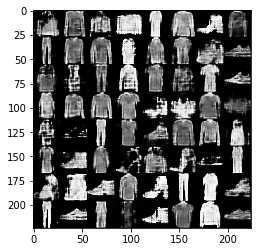

In [18]:
import cv2
import matplotlib.pyplot as plt

im = cv2.imread('/content/results/fashion-mnist/GAN/GAN_epoch001.png')
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)


plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

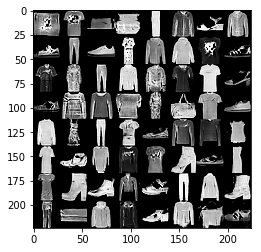

In [19]:
im = cv2.imread('/content/results/fashion-mnist/GAN/GAN_epoch050.png')
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

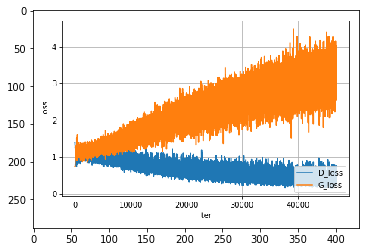

In [20]:
import matplotlib.image as mpimg
img=mpimg.imread('/content/models/fashion-mnist/GAN/GAN_loss.png')
imgplot = plt.imshow(img)
plt.show()